# Weather Temperature Prediction 

The goal is to predict the temperature (t2m) using the available features, making use of geospatial and temporal patterns in the data.

### 1. Loading and Initial Data Exploration

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Set plotting styles and parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the data
print("Loading training and test datasets...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic information
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display the first few rows of the training data
train_df.head()

Loading training and test datasets...
Training data shape: (13288920, 13)
Test data shape: (13288920, 12)


,id,valid_time,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m
0,1,2018-01-01 00:00:00,59.00,-8.00,0.00,1.41,-1.37,98134.81,1.52,-1.47,0.97,1.00,279.76
1,2,2018-01-01 00:00:00,59.00,-7.75,0.00,2.15,-1.56,98086.81,2.24,-1.63,0.98,1.00,279.61
2,3,2018-01-01 00:00:00,59.00,-7.50,0.00,2.69,-1.59,98078.81,2.78,-1.69,0.98,1.00,279.72
3,4,2018-01-01 00:00:00,59.00,-7.25,0.00,2.85,-1.71,98076.81,2.97,-1.85,0.98,1.00,279.78
4,5,2018-01-01 00:00:00,59.00,-7.00,0.00,3.30,-1.87,98084.81,3.46,-2.00,0.97,1.00,279.87


In [2]:
# Check data types
print("Training data types:")
train_df.dtypes

# Summary statistics
print("\nSummary statistics for numerical columns:")
train_df.describe()

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Training data types:

Summary statistics for numerical columns:

Missing values in training data:
id            0
valid_time    0
latitude      0
longitude     0
tp            0
u10           0
v10           0
sp            0
u100          0
v100          0
tcc           0
ptype         0
t2m           0
dtype: int64

Missing values in test data:
id            0
valid_time    0
latitude      0
longitude     0
tp            0
u10           0
v10           0
sp            0
u100          0
v100          0
tcc           0
ptype         0
dtype: int64


### 2. Data Type Conversion and Basic Preprocessing
Convert the date-time column and create additional time-related features.

In [18]:
# Convert 'valid_time' to datetime
train_df['valid_time'] = pd.to_datetime(train_df['valid_time'])
test_df['valid_time'] = pd.to_datetime(test_df['valid_time'])

# Extract date components for time-based analysis
for df in [train_df, test_df]:
    df['year'] = df['valid_time'].dt.year
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.day
    df['hour'] = df['valid_time'].dt.hour
    df['dayofweek'] = df['valid_time'].dt.dayofweek
    df['dayofyear'] = df['valid_time'].dt.dayofyear
    # Season encoding (1=Winter, 2=Spring, 3=Summer, 4=Fall)
    df['season'] = (df['month'] % 12 + 3) // 3

# Check the updated dataframe
train_df[['valid_time', 'year', 'month', 'day', 'hour', 'season']].head()

,valid_time,year,month,day,hour,season
0,2018-01-01,2018,1,1,0,1
1,2018-01-01,2018,1,1,0,1
2,2018-01-01,2018,1,1,0,1
3,2018-01-01,2018,1,1,0,1
4,2018-01-01,2018,1,1,0,1


### 3. Basic Data Visualization and Distribution Analysis
Visualising the distribution of our target variable and other numerical features.

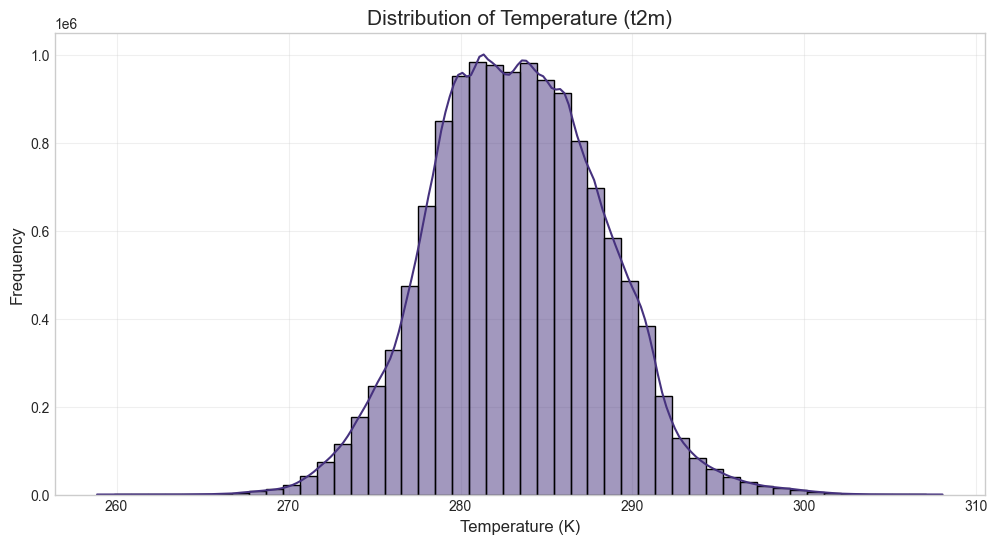

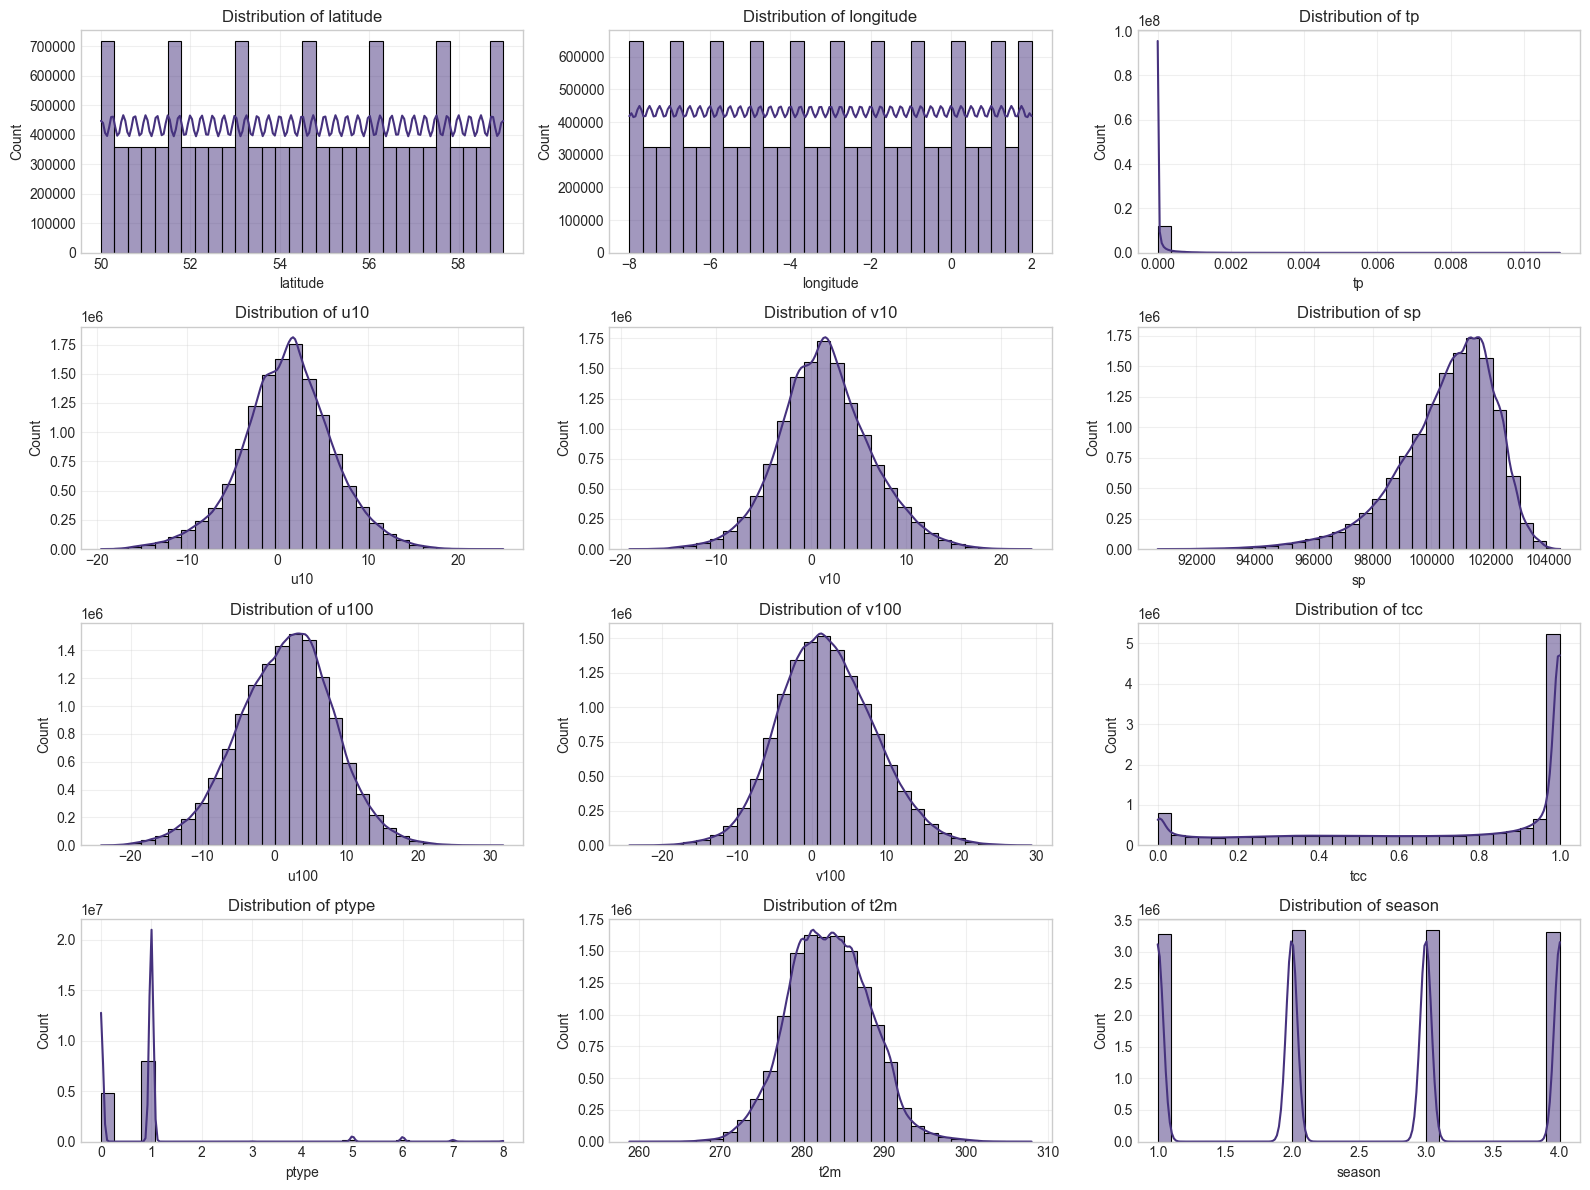

In [4]:
# Distribution of target variable
plt.figure(figsize=(12, 6))
sns.histplot(train_df['t2m'], kde=True, bins=50)
plt.title('Distribution of Temperature (t2m)', fontsize=15)
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Create a function to plot histograms for all numerical features
def plot_feature_distributions(df, columns=None, bins=30, figsize=(16, 12)):
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, bins=bins, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()

# Plot distributions of all continuous features (excluding datetime and ID)
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear']]
plot_feature_distributions(train_df, columns=numeric_cols)

The geographic distribution of data to examine how temperature varies spatially.

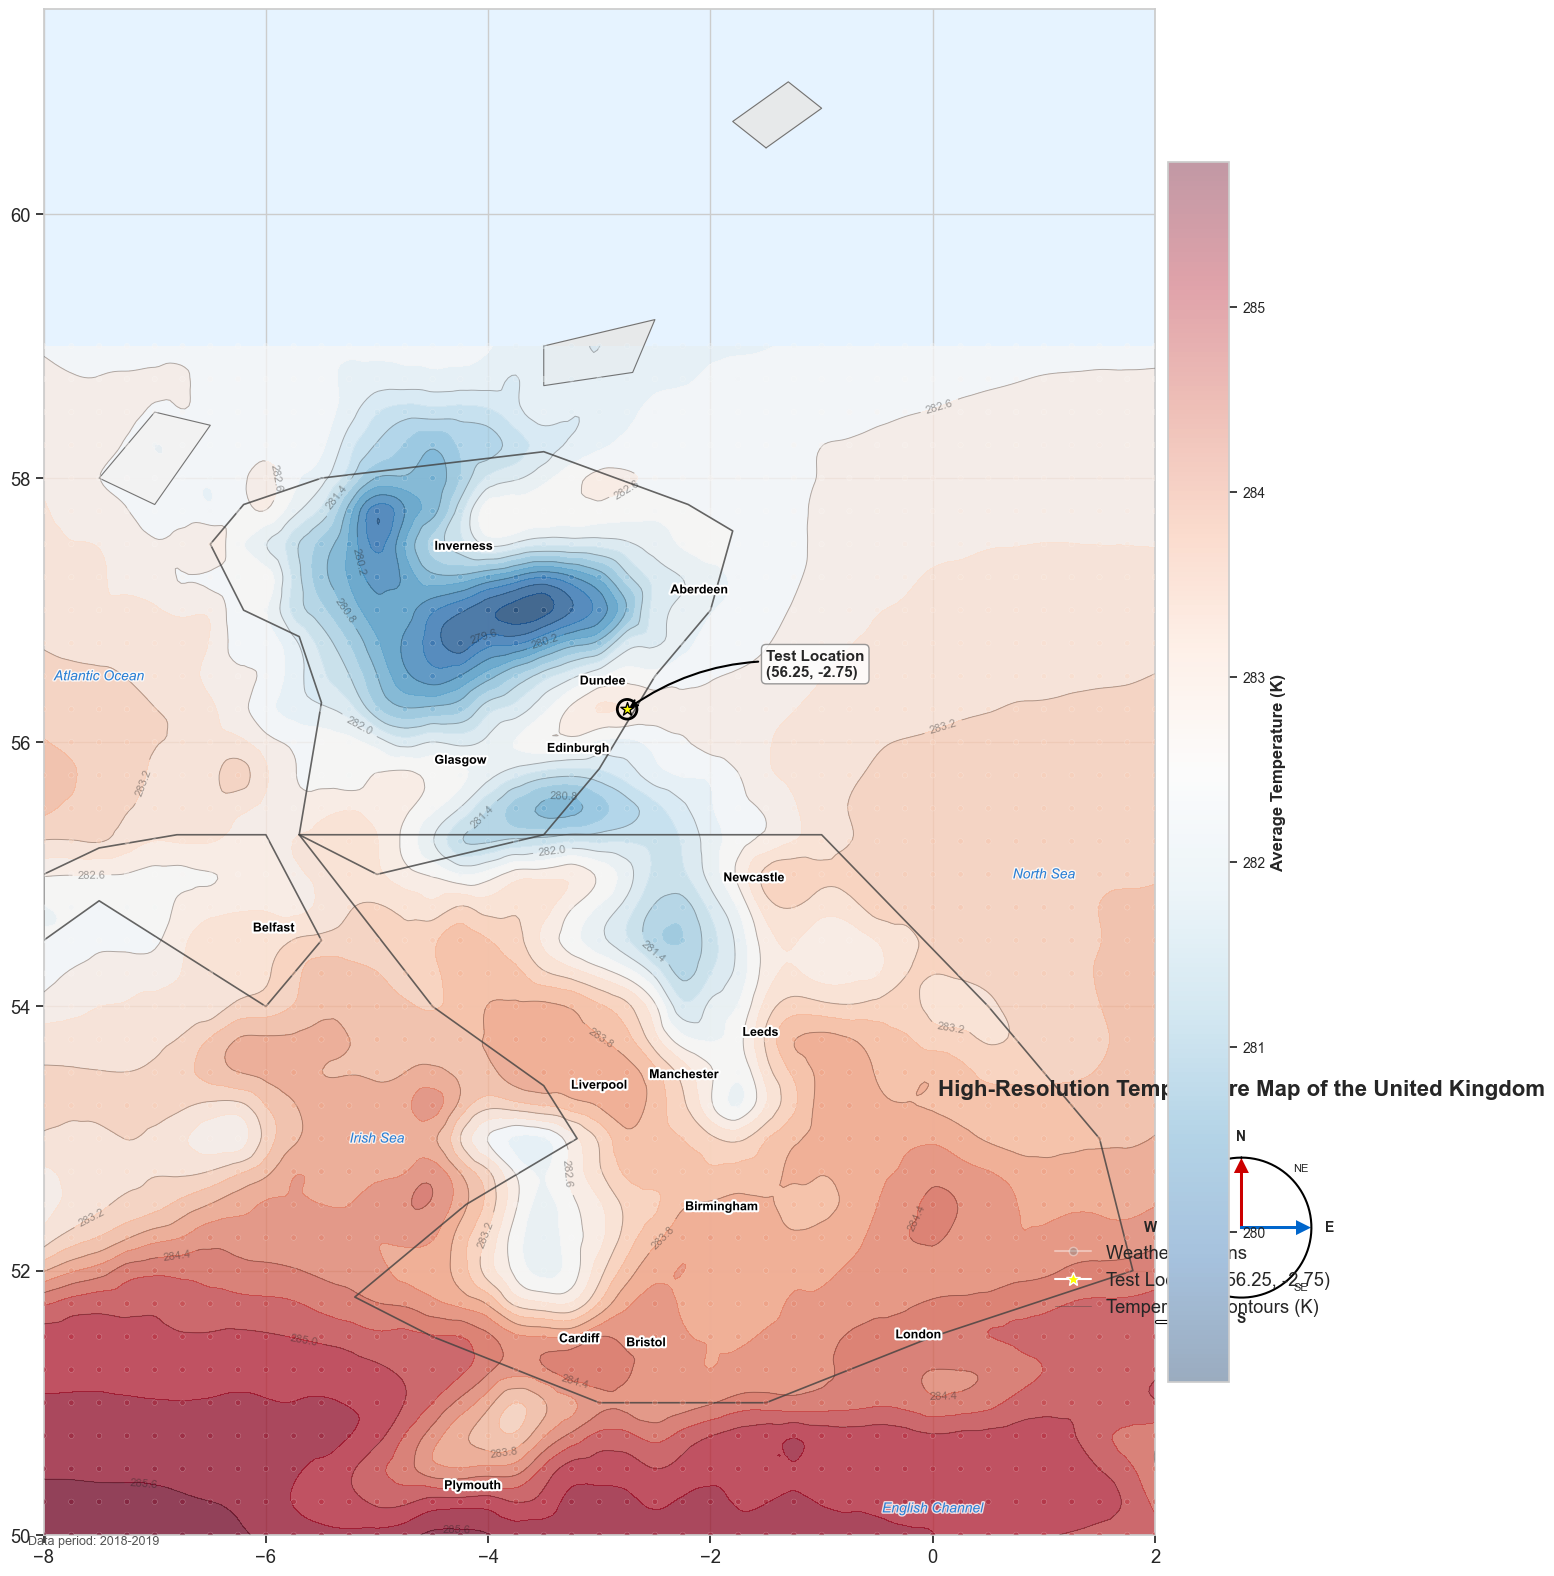

In [17]:
# Enhanced geographical visualization using only standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
from scipy.interpolate import griddata
import seaborn as sns

# Set figure aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Prepare the data
temp_by_location = train_df.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()

# Create a custom colormap for temperature
colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', 
          '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
cmap = LinearSegmentedColormap.from_list('temp_cmap', colors, N=256)

# Create a higher resolution grid for smoother interpolation
grid_lon, grid_lat = np.meshgrid(
    np.linspace(temp_by_location.longitude.min(), temp_by_location.longitude.max(), 300),
    np.linspace(temp_by_location.latitude.min(), temp_by_location.latitude.max(), 300)
)

# Interpolate temperature values to the grid using cubic interpolation
grid_temp = griddata(
    (temp_by_location.longitude, temp_by_location.latitude), 
    temp_by_location.t2m, 
    (grid_lon, grid_lat), 
    method='cubic'
)

# Create detailed UK outline
uk_outline = {
    # More detailed Scotland outline
    'scotland': [
        (-5.5, 58.0), (-6.2, 57.8), (-6.5, 57.5), (-6.2, 57.0),
        (-5.7, 56.8), (-5.5, 56.3), (-5.7, 55.3), (-5.0, 55.0),
        (-3.5, 55.3), (-3.0, 55.8), (-2.5, 56.5), (-2.0, 57.0),
        (-1.8, 57.6), (-2.2, 57.8), (-3.5, 58.2), (-5.5, 58.0)
    ],
    # Enhanced England and Wales
    'england_wales': [
        (-5.7, 55.3), (-4.5, 54.0), (-3.5, 53.4), (-3.2, 53.0), 
        (-4.2, 52.5), (-5.2, 51.8), (-4.5, 51.5), (-3.0, 51.0), 
        (-1.5, 51.0), (0.0, 51.5), (1.8, 52.0), (1.5, 53.0),
        (0.5, 54.0), (-1.0, 55.3), (-5.7, 55.3)
    ],
    # Enhanced Northern Ireland
    'northern_ireland': [
        (-8.0, 55.0), (-7.5, 55.2), (-6.8, 55.3), (-6.0, 55.3), 
        (-5.5, 54.5), (-6.0, 54.0), (-7.5, 54.8), (-8.0, 54.5), (-8.0, 55.0)
    ],
    # Add Outer Hebrides
    'outer_hebrides': [
        (-7.5, 58.0), (-7.0, 58.5), (-6.5, 58.4), (-7.0, 57.8), (-7.5, 58.0)
    ],
    # Add Orkney Islands
    'orkney': [
        (-3.5, 59.0), (-2.5, 59.2), (-2.7, 58.8), (-3.5, 58.7), (-3.5, 59.0)
    ]
}

# Create figure with larger size and custom background
plt.figure(figsize=(14, 16))
ax = plt.axes()

# Set ocean background color
ax.set_facecolor('#e6f3ff')  # Light blue for ocean

# Create a more sophisticated land effect before plotting data
for region in ['england_wales', 'scotland', 'northern_ireland', 'outer_hebrides', 'orkney']:
    coords = uk_outline[region]
    xs, ys = zip(*coords)
    # Land fill with subtle terrain effect
    plt.fill(xs, ys, color='#f5f5f0', alpha=0.9, zorder=1)  # Light beige/gray for land
    # Coastal highlight
    plt.plot(xs, ys, color='#404040', linewidth=1.2, alpha=0.8, zorder=3)

# Plot the interpolated temperature surface with improved aesthetics
contour = plt.contourf(grid_lon, grid_lat, grid_temp, levels=25, cmap=cmap, alpha=0.75, zorder=2)

# Add contour lines with labels
contour_lines = plt.contour(grid_lon, grid_lat, grid_temp, levels=12, 
                           colors='#404040', alpha=0.4, linewidths=0.7, zorder=4)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f', colors='#202020')

# Add data points (smaller and more subtle)
scatter = plt.scatter(
    temp_by_location.longitude, 
    temp_by_location.latitude,
    c=temp_by_location.t2m, 
    cmap=cmap,
    s=15,  # Smaller points
    alpha=0.4,  # More transparent
    edgecolor='white',
    linewidth=0.3,
    zorder=5
)

# Add major cities and landmarks
cities = {
    'London': (-0.13, 51.51),
    'Edinburgh': (-3.19, 55.95),
    'Cardiff': (-3.18, 51.48),
    'Belfast': (-5.93, 54.59),
    'Manchester': (-2.24, 53.48),
    'Glasgow': (-4.25, 55.86),
    'Liverpool': (-3.0, 53.4),
    'Birmingham': (-1.9, 52.48),
    'Bristol': (-2.58, 51.45),
    'Newcastle': (-1.61, 54.97),
    'Aberdeen': (-2.1, 57.15),
    'Inverness': (-4.22, 57.48),
    'Dundee': (-2.97, 56.46)
}

# Improved city labels with better visibility
for city, (lon, lat) in cities.items():
    # Check if city is within data bounds
    if (temp_by_location.longitude.min() <= lon <= temp_by_location.longitude.max() and
        temp_by_location.latitude.min() <= lat <= temp_by_location.latitude.max()):
        txt = plt.text(lon, lat, city, fontsize=9, ha='center', va='center', 
                      color='black', weight='bold', zorder=10)
        # Add white outline for better visibility
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add main geographical features
geo_features = {
    'North Sea': (1.0, 55.0),
    'Atlantic Ocean': (-7.5, 56.5),
    'Irish Sea': (-5.0, 53.0),
    'English Channel': (0.0, 50.2)
}

for feature, (lon, lat) in geo_features.items():
    # Water features in blue, italic
    txt = plt.text(lon, lat, feature, fontsize=10, ha='center', va='center', 
                  color='#0066cc', style='italic', alpha=0.8, zorder=9)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Highlight test location (56.25, -2.75)
plt.scatter(-2.75, 56.25, s=200, c='none', edgecolor='black', linewidth=2, marker='o', zorder=20)
plt.scatter(-2.75, 56.25, s=100, c='yellow', edgecolor='black', linewidth=1, marker='*', zorder=21)

# Add annotation with better styling
plt.annotate('Test Location\n(56.25, -2.75)', 
             xy=(-2.75, 56.25), 
             xytext=(-1.5, 56.5), 
             fontsize=11, 
             fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                           color='black', lw=1.5),
             zorder=22)

# Add compass rose
compass_size = 0.15
compass_pos = [0.82, 0.15, compass_size, compass_size]
compass_ax = plt.axes(compass_pos)
compass_ax.set_aspect('equal')

# Create detailed compass
theta = np.linspace(0, 2*np.pi, 100)
r = np.ones_like(theta)
compass_ax.plot(r*np.sin(theta), r*np.cos(theta), 'k-', lw=1.5)

# Add directional points
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
angles = np.arange(0, 2*np.pi, np.pi/4)
for direction, angle in zip(directions, angles):
    x, y = 1.2*np.sin(angle), 1.2*np.cos(angle)
    if direction == 'N':
        compass_ax.text(x, y, direction, ha='center', va='bottom', fontweight='bold', fontsize=10)
    elif direction == 'S':
        compass_ax.text(x, y, direction, ha='center', va='top', fontweight='bold', fontsize=10)
    elif direction == 'E':
        compass_ax.text(x, y, direction, ha='left', va='center', fontweight='bold', fontsize=10)
    elif direction == 'W':
        compass_ax.text(x, y, direction, ha='right', va='center', fontweight='bold', fontsize=10)
    else:
        compass_ax.text(x, y, direction, ha='center', va='center', fontsize=8)

# Main arrows
for angle, color in zip([0, np.pi/2], ['#cc0000', '#0066cc']):
    dx, dy = np.sin(angle), np.cos(angle)
    compass_ax.arrow(0, 0, 0.8*dx, 0.8*dy, head_width=0.15, head_length=0.15, 
                    fc=color, ec=color, lw=2)

compass_ax.set_xlim(-1.5, 1.5)
compass_ax.set_ylim(-1.5, 1.5)
compass_ax.set_axis_off()

# Add scale bar
scale_length_deg = 1.0  # Length in degrees longitude
lon_scale = np.cos(np.radians(56)) * 111  # km per degree longitude at this latitude
scale_length_km = lon_scale * scale_length_deg

# Position scale bar
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
scale_x_start = x_min + 0.1 * (x_max - x_min)
scale_y = y_min + 0.05 * (y_max - y_min)

# Draw scale bar with improved styling
plt.plot([scale_x_start, scale_x_start + scale_length_deg], 
         [scale_y, scale_y], 'k-', linewidth=3)
plt.plot([scale_x_start, scale_x_start + scale_length_deg], 
         [scale_y, scale_y], 'w-', linewidth=1.5)

# Add km label with shadow
scale_txt = plt.text(scale_x_start + scale_length_deg/2, scale_y - 0.2, 
                    f'~{scale_length_km:.0f} km', 
                    ha='center', fontsize=9, fontweight='bold')
scale_txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Add better gridlines
plt.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add colorbar with better styling
cbar = plt.colorbar(scatter, pad=0.01, shrink=0.8, aspect=20)
cbar.set_label('Average Temperature (K)', fontsize=12, weight='bold')
cbar.ax.tick_params(labelsize=10)

# Add title and labels
plt.title('High-Resolution Temperature Map of the United Kingdom', 
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Longitude', fontsize=12, weight='bold')
plt.ylabel('Latitude', fontsize=12, weight='bold')

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, alpha=0.4,
              label='Weather Stations'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow', markersize=10,
              label='Test Location (56.25, -2.75)'),
    plt.Line2D([0], [0], color='#404040', lw=0.7, alpha=0.4,
              label='Temperature Contours (K)')
]
plt.legend(handles=legend_elements, loc='lower right', framealpha=0.7)

# Add date info
plt.annotate('Data period: 2018-2019', xy=(0.02, 0.02), xycoords='figure fraction', 
            fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

# Create a second visualization showing seasonal temperature variation
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a figure for seasonal comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i, (season_name, months) in enumerate(seasons.items()):
    # Get data for this season
    season_data = train_df[train_df['month'].isin(months)]
    season_temp = season_data.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()
    
    # Interpolate to grid
    season_grid = griddata(
        (season_temp.longitude, season_temp.latitude), 
        season_temp.t2m, 
        (grid_lon, grid_lat), 
        method='cubic'
    )
    
    # Set background color
    axes[i].set_facecolor('#e6f3ff')
    
    # Add UK land
    for region in ['england_wales', 'scotland', 'northern_ireland', 'outer_hebrides', 'orkney']:
        coords = uk_outline[region]
        xs, ys = zip(*coords)
        axes[i].fill(xs, ys, color='#f5f5f0', alpha=0.9, zorder=1)
        axes[i].plot(xs, ys, color='#404040', linewidth=0.8, alpha=0.7, zorder=3)
    
    # Plot contours
    contour = axes[i].contourf(grid_lon, grid_lat, season_grid, levels=20, cmap=cmap, alpha=0.8)
    
    # Add contour lines
    contour_lines = axes[i].contour(grid_lon, grid_lat, season_grid, 
                                   levels=10, colors='black', alpha=0.4, linewidths=0.5)
    axes[i].clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f')
    
    # Add test location highlight
    axes[i].scatter(-2.75, 56.25, s=100, c='none', edgecolor='black', linewidth=1, marker='o')
    axes[i].scatter(-2.75, 56.25, s=50, c='yellow', edgecolor='black', linewidth=0.5, marker='*')
    
    # Add city markers - just a few key cities for each subplot
    major_cities = {k: cities[k] for k in ['London', 'Edinburgh', 'Cardiff', 'Belfast']}
    for city, (lon, lat) in major_cities.items():
        if (season_temp.longitude.min() <= lon <= season_temp.longitude.max() and
            season_temp.latitude.min() <= lat <= season_temp.latitude.max()):
            txt = axes[i].text(lon, lat, city, fontsize=8, ha='center', va='center', 
                         color='black', weight='bold', zorder=7)
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
    
    # Set limits and labels
    axes[i].set_xlim(temp_by_location.longitude.min() - 0.5, temp_by_location.longitude.max() + 0.5)
    axes[i].set_ylim(temp_by_location.latitude.min() - 0.5, temp_by_location.latitude.max() + 0.5)
    axes[i].set_xlabel('Longitude', fontsize=10)
    axes[i].set_ylabel('Latitude', fontsize=10)
    axes[i].set_title(f'{season_name} Average Temperature', fontsize=14, weight='bold')
    axes[i].grid(True, alpha=0.3, linestyle='--')

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Average Temperature (K)', fontsize=12, weight='bold')

plt.suptitle('Seasonal Temperature Variation Across the UK', fontsize=18, weight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

### 4. Temporal Analysis
Analyse how temperature and other variables change over time.

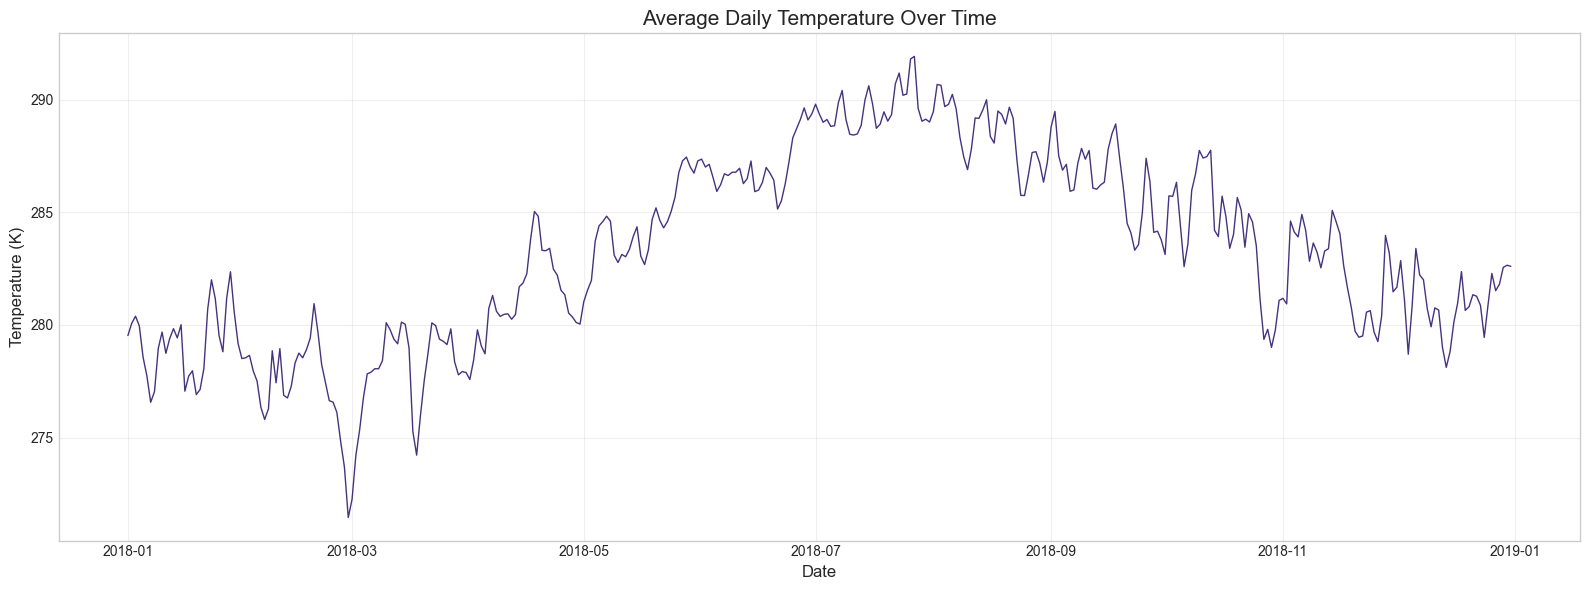

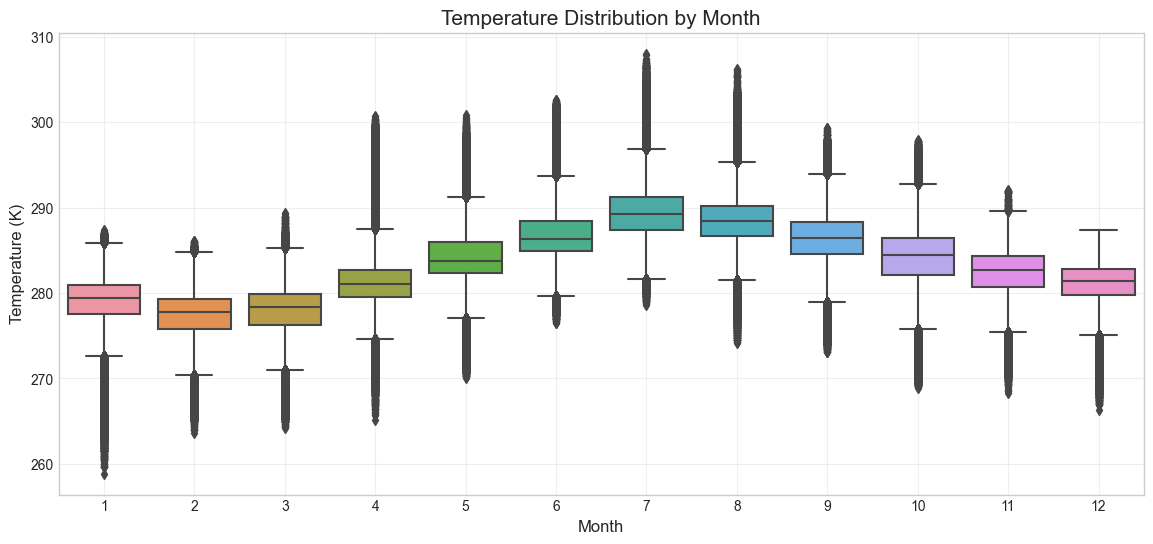

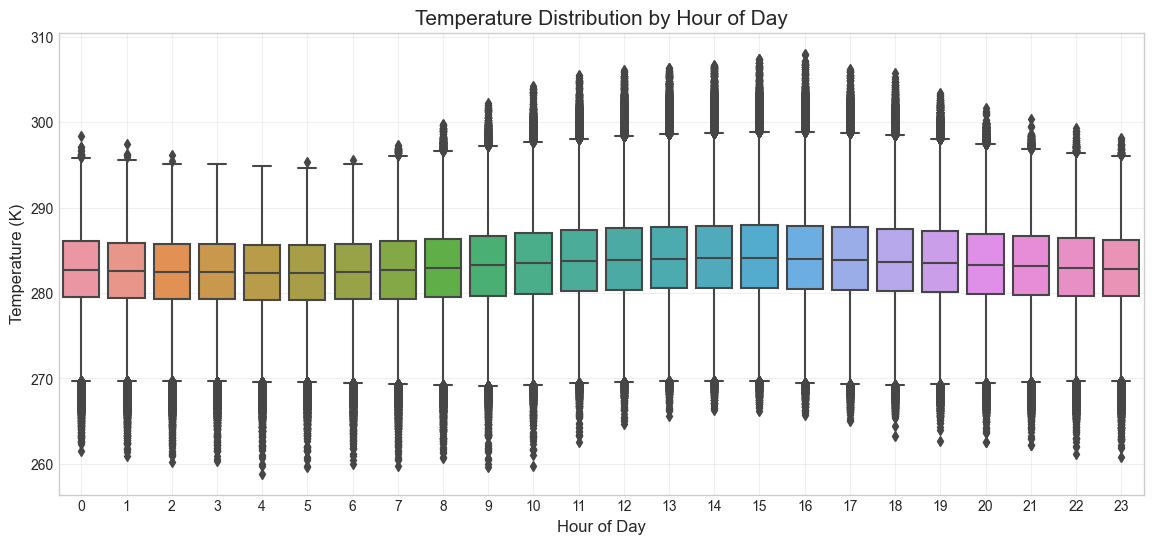

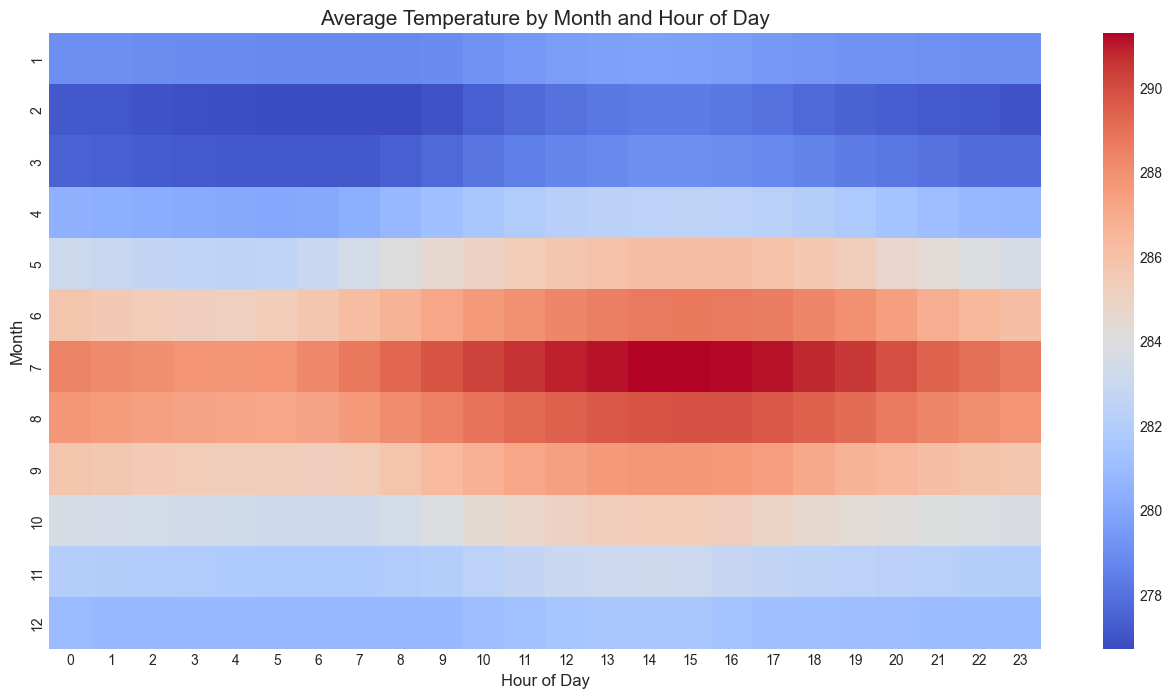

In [6]:
# Group by date and calculate mean temperature
daily_temp = train_df.groupby(train_df['valid_time'].dt.date)['t2m'].mean().reset_index()
daily_temp['valid_time'] = pd.to_datetime(daily_temp['valid_time'])

plt.figure(figsize=(16, 6))
plt.plot(daily_temp['valid_time'], daily_temp['t2m'], '-', linewidth=1)
plt.title('Average Daily Temperature Over Time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Temperature by month (boxplot)
plt.figure(figsize=(14, 6))
sns.boxplot(x='month', y='t2m', data=train_df)
plt.title('Temperature Distribution by Month', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Temperature by hour of day
plt.figure(figsize=(14, 6))
sns.boxplot(x='hour', y='t2m', data=train_df)
plt.title('Temperature Distribution by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Create a heatmap showing temperature by month and hour
temp_heatmap = train_df.pivot_table(values='t2m', index='month', columns='hour', aggfunc='mean')
plt.figure(figsize=(16, 8))
sns.heatmap(temp_heatmap, cmap='coolwarm', annot=False, fmt='.1f')
plt.title('Average Temperature by Month and Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.show()

### 5. Correlation Analysis
Examine the relationships between variables.

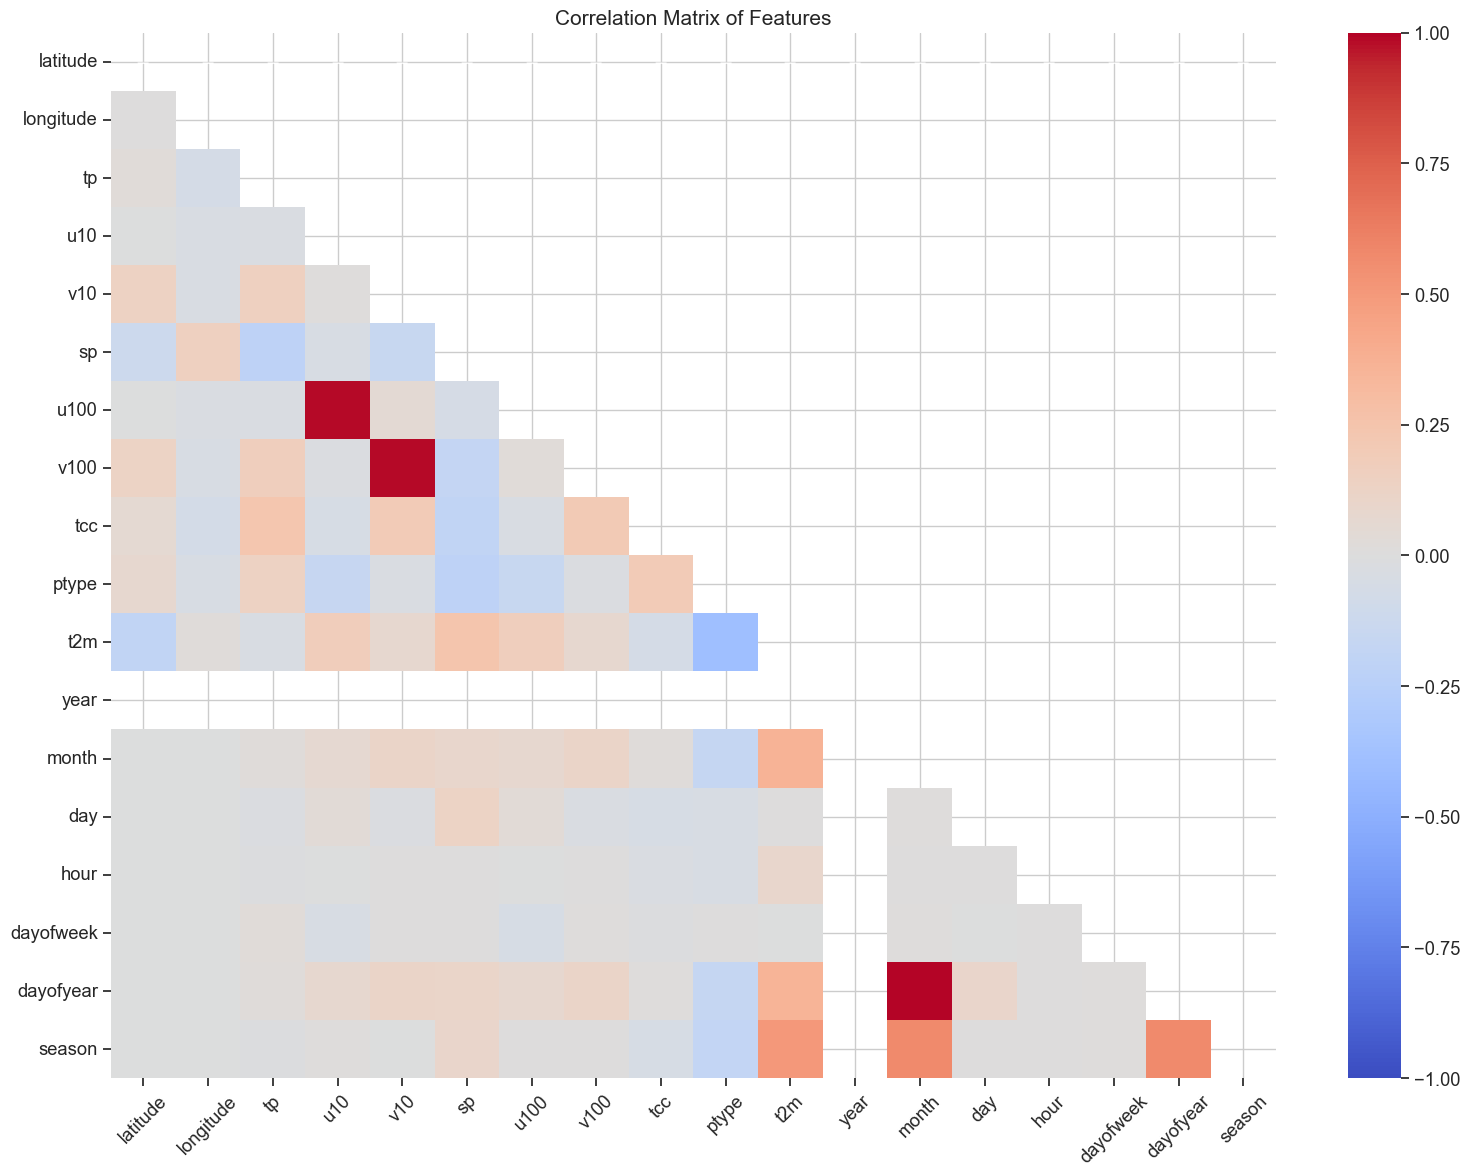

In [ ]:
# Correlation matrix
correlation_cols = [col for col in train_df.columns if col not in ['id', 'valid_time']]
correlation_matrix = train_df[correlation_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            mask=np.triu(correlation_matrix), vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Pairplot of key variables
key_vars = ['t2m', 'tp', 'sp', 'tcc']
plt.figure(figsize=(16, 12))
sns.pairplot(train_df[key_vars], diag_kind='kde')
plt.suptitle('Pairplot of Key Variables', fontsize=16, y=1.02)
plt.show()

# Create scatter plots of most correlated features with temperature
top_corr = correlation_matrix['t2m'].abs().sort_values(ascending=False)
top_features = top_corr.index[1:6]  # Skip t2m itself
print(f"Top 5 correlated features with temperature: {', '.join(top_features)}")

plt.figure(figsize=(18, 12))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(train_df[feature], train_df['t2m'], alpha=0.3, s=10)
    plt.title(f'{feature} vs Temperature', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Temperature (K)', fontsize=12)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()